In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Вспомогательные функции

In [2]:
def load_image(image_path, flag_color=0):
    img = Image.open(image_path).convert('L')
    if flag_color == 1:  img = Image.open(image_path)
    img_array = np.array(img)
    
    return img_array

In [3]:
def gram_schmidt(V):
    U = np.zeros_like(V, dtype=np.float64)
    for i in range(V.shape[1]):
        u = V[:, i].copy().astype(np.float64)
        for j in range(i):
            proj = np.dot(U[:, j], V[:, i]) / np.dot(U[:, j], U[:, j])
            u = u - proj * U[:, j]
        
        norm = np.linalg.norm(u)
        if norm > 1e-10:
            U[:, i] = u / norm
        else:
            # eсли вектор почти нулевой, используем случайный ортогональный
            U[:, i] = np.random.randn(V.shape[0])
            for j in range(i):
                proj = np.dot(U[:, j], U[:, i]) / np.dot(U[:, j], U[:, j])
                U[:, i] = U[:, i] - proj * U[:, j]
            U[:, i] = U[:, i] / np.linalg.norm(U[:, i])
    
    return U

In [4]:
def calculate_compression_ratio(original_image, k, flag_color=0):
    ratio = 0
    if flag_color == 0:
        orig_rows, orig_cols = original_image.shape
        original_size = orig_rows * orig_cols
        compressed_size = k * (orig_rows + orig_cols + 1)
        ratio = original_size / compressed_size
    
    if flag_color == 1:
        h, w, c = original_image.shape
        original_size = h * w * c
        compressed_size = 3 * k * (h + w + 1)
        ratio = original_size / compressed_size
    return ratio

In [5]:
def calculate_psnr(image_array, compressed):
    mse = np.mean((image_array - compressed)**2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    return psnr

In [6]:
def display_images(original, compressed, k, compression_ratio):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'Оригинальное изображение\nРазмер: {original.shape}')
    axes[0].axis('off')
    
    axes[1].imshow(compressed, cmap='gray')
    axes[1].set_title(f'Сжатое изображение (k={k})\nКоэффициент сжатия: {compression_ratio:.2f}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

## SVD-разложение + сжатие изображения

In [7]:
def fast_approximate_svd(A, k, iterations=5):
    orig_rows, orig_cols = A.shape
    U_approx = np.zeros((orig_rows, k))
    Vt_approx = np.zeros((k, orig_cols))
    B = A.copy().astype(np.float64)
    
    for i in range(k):
        v = np.random.randn(orig_cols)
        v = v / np.linalg.norm(v)
        
        # u - левый сингулярный вектор, v - левый сингулярный вектор
        for _ in range(iterations):
            u = B @ v
            u = u / (np.linalg.norm(u) + 1e-10)
            v = B.T @ u
            v = v / (np.linalg.norm(v) + 1e-10)
        
        u = B @ v
        sigma = np.linalg.norm(u)
        
        if sigma > 1e-10:
            u = u / sigma
            U_approx[:, i] = u
            Vt_approx[i, :] = v
            B = B - sigma * np.outer(u, v)
        else:
            U_approx[:, i] = np.zeros(orig_rows)
            Vt_approx[i, :] = np.zeros(orig_cols)
    
    return U_approx, Vt_approx

In [8]:
def orthogonalize_and_recompute(A, U_approx, Vt_approx):
    k = U_approx.shape[1]
    U_orth = gram_schmidt(U_approx)
    Vt_orth = gram_schmidt(Vt_approx.T).T
    V_orth = Vt_orth.T
    # S = U^T @ A @ V
    S_matrix = U_orth.T @ A @ V_orth
    S_diag = np.diag(S_matrix)

    sorted_indices = np.argsort(S_diag)[::-1]
    S_diag = S_diag[sorted_indices]
    U_orth = U_orth[:, sorted_indices]
    Vt_orth = Vt_orth[sorted_indices, :]
    
    np.fill_diagonal(S_matrix, S_diag)
    
    return U_orth, S_matrix, Vt_orth

In [9]:
def compress_image(image_array, k, max_iter=50):
    mean = np.mean(image_array)
    image_array_centered = image_array - mean
    
    U, Vt = fast_approximate_svd(image_array_centered, k, max_iter)
    U_orth, S, Vt_orth = orthogonalize_and_recompute(image_array_centered, U, Vt)
    
    compressed_image_centered = U_orth @ S @ Vt_orth
    compressed_image = compressed_image_centered + mean
    compressed_image= np.clip(compressed_image, 0, 255)
    
    return compressed_image.astype(np.uint8)

## Ч/б изображения

Изображение загружено. Размер: (2956, 1960)

--- Сжатие с k=10 ---
Коэффициент сжатия: 117.83
PSNR: 28.9 dB


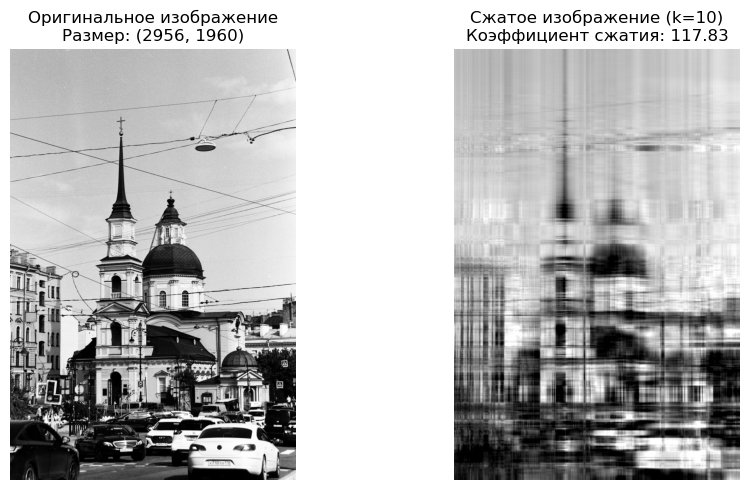


--- Сжатие с k=50 ---
Коэффициент сжатия: 23.57
PSNR: 29.7 dB


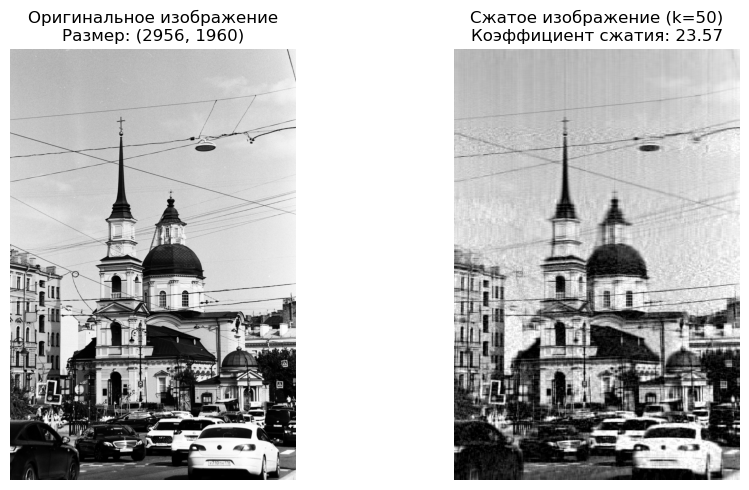


--- Сжатие с k=100 ---
Коэффициент сжатия: 11.78
PSNR: 30.3 dB


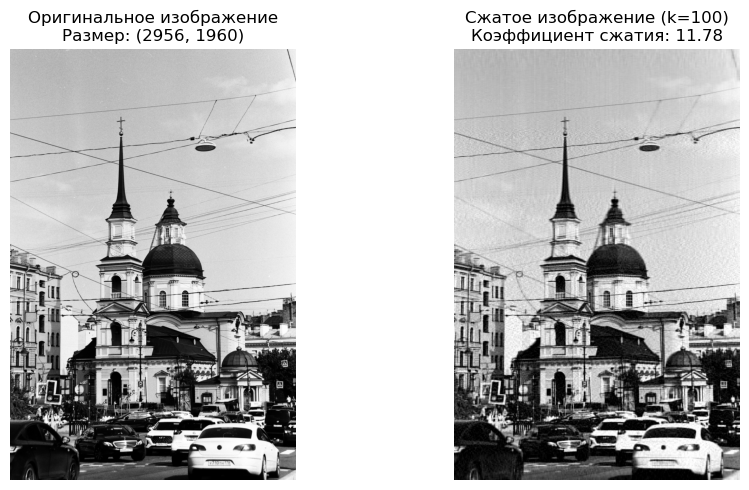

In [10]:
image_path = "image_for_svd_black_2.jpg"
k_values = [10, 50, 100]
# k_values = [100]

original_image = load_image(image_path)
print(f"Изображение загружено. Размер: {original_image.shape}")

for k in k_values:
    if k > min(original_image.shape):
        print(f"k={k} слишком велико для этого изображения")
        continue
        
    print(f"\n--- Сжатие с k={k} ---")
    compressed_image = compress_image(original_image, k)
    compression_ratio = calculate_compression_ratio(original_image, k)
    psnr = calculate_psnr(original_image, compressed_image)
    
    print(f"Коэффициент сжатия: {compression_ratio:.2f}")
    print(f"PSNR: {psnr:.1f} dB")
    
    display_images(original_image, compressed_image, k, compression_ratio)

## RGB изображения

In [11]:
def compress_rgb_image(image_array, k=30):
    R = image_array[:, :, 0].astype(np.float64)
    G = image_array[:, :, 1].astype(np.float64)
    B = image_array[:, :, 2].astype(np.float64)
    compressed_channels = []
    
    for i, channel in enumerate([R, G, B]):
        compressed_ch = compress_image(channel, k)
        compressed_channels.append(compressed_ch)
        
    compressed_color = np.stack(compressed_channels, axis=2).astype(np.uint8)
    return compressed_color

В децибелах (dB):
PSNR > 40 dB → Отличное качество, различия невидимы

PSNR = 30-40 dB → Хорошее качество, различия едва заметны

PSNR = 20-30 dB → Приемлемое качество, различия заметны

PSNR < 20 dB → Плохое качество, сильные искажения

Изображение загружено. Размер: (1023, 829, 3)

--- Сжатие с k=10 ---
Коэффициент сжатия: 45.77
PSNR: 29.5 dB


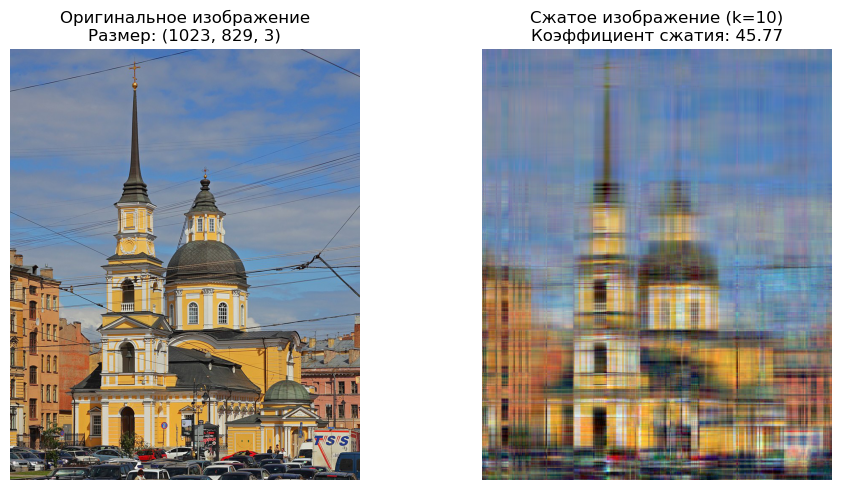


--- Сжатие с k=50 ---
Коэффициент сжатия: 9.15
PSNR: 30.6 dB


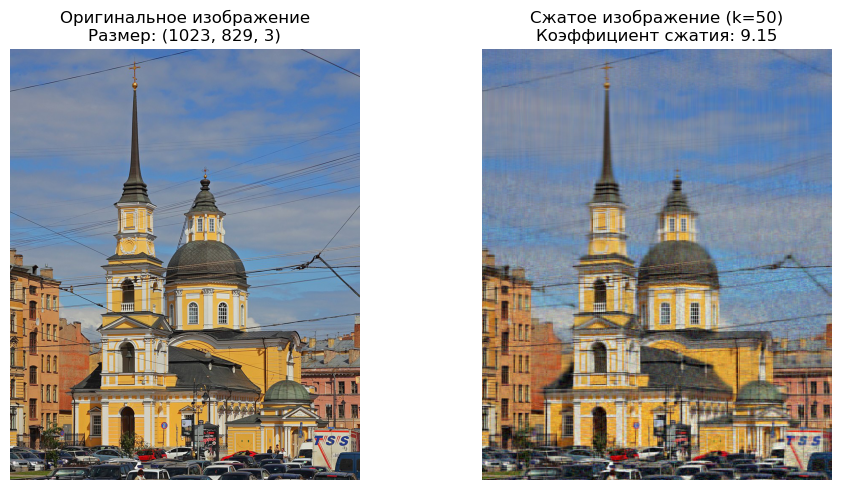


--- Сжатие с k=100 ---
Коэффициент сжатия: 4.58
PSNR: 31.1 dB


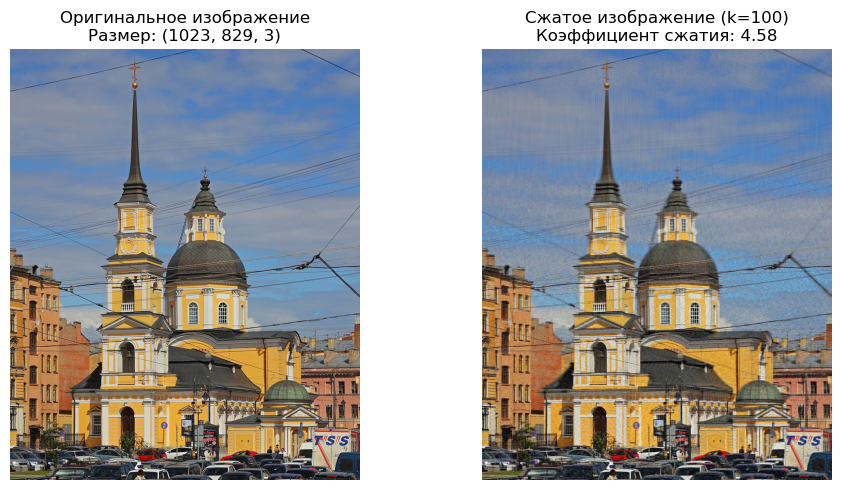

In [12]:
image_path_rgb = "image_for_svd_color.jpg"
k_values = [10, 50, 100]
# k_values = [100]

original_image_rgb = load_image(image_path_rgb, flag_color=1)
print(f"Изображение загружено. Размер: {original_image_rgb.shape}")

for k in k_values:
    if k > min(original_image_rgb.shape[:2]):
        print(f"k={k} слишком велико для этого изображения")
        continue
        
    print(f"\n--- Сжатие с k={k} ---")
    compressed_color = compress_rgb_image(original_image_rgb, k)
    compression_ratio = calculate_compression_ratio(original_image_rgb, k, flag_color=1)
    psnr_rgb = calculate_psnr(original_image_rgb, compressed_color)
    
    print(f"Коэффициент сжатия: {compression_ratio:.2f}")
    print(f"PSNR: {psnr_rgb:.1f} dB")
    
    display_images(original_image_rgb, compressed_color, k, compression_ratio)